In [1]:
# 전처리 수행
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("ner_datasetreference.csv", encoding="latin1")

In [3]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [5]:
print("{:^12}{:^5}".format("컬럼", "null 수량"))
print("-"*25)
print(data.isnull().sum())

     컬럼     null 수량
-------------------------
Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [6]:
data['Sentence'] = data['Sentence #']
del data['Sentence #']

In [7]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data.Sentence.nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [8]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [9]:
data = data.fillna(method="ffill")
print(data.tail())

              Word  POS Tag         Sentence
1048570       they  PRP   O  Sentence: 47959
1048571  responded  VBD   O  Sentence: 47959
1048572         to   TO   O  Sentence: 47959
1048573        the   DT   O  Sentence: 47959
1048574     attack   NN   O  Sentence: 47959


In [10]:
data['Word'] = data['Word'].str.lower()
print('Word 열 개수 : {}'.format(data.Word.nunique()))

Word 열 개수 : 31817


In [11]:
print(data[-5:])

              Word  POS Tag         Sentence
1048570       they  PRP   O  Sentence: 47959
1048571  responded  VBD   O  Sentence: 47959
1048572         to   TO   O  Sentence: 47959
1048573        the   DT   O  Sentence: 47959
1048574     attack   NN   O  Sentence: 47959


In [12]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [13]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [14]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보 저장
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보 저장

In [15]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


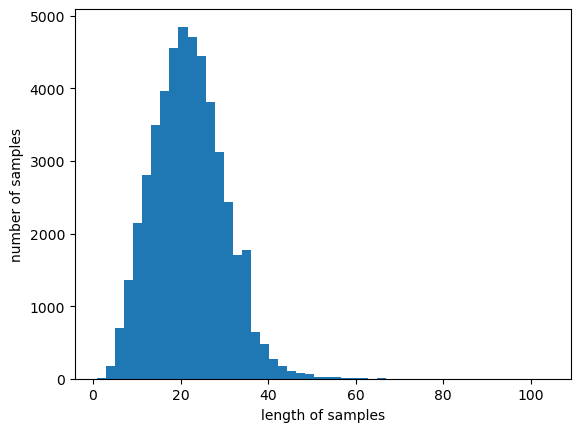

In [16]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [18]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [19]:
src_tokenizer.word_index

{'OOV': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'in': 5,
 'of': 6,
 'to': 7,
 'a': 8,
 'and': 9,
 "'s": 10,
 'for': 11,
 'has': 12,
 'on': 13,
 'is': 14,
 'that': 15,
 'have': 16,
 'with': 17,
 'said': 18,
 'was': 19,
 'at': 20,
 'says': 21,
 'from': 22,
 'by': 23,
 'he': 24,
 'an': 25,
 'as': 26,
 'say': 27,
 'u.s.': 28,
 'it': 29,
 'are': 30,
 '"': 31,
 'were': 32,
 'his': 33,
 'will': 34,
 'president': 35,
 'officials': 36,
 'government': 37,
 'mr.': 38,
 'been': 39,
 'killed': 40,
 'two': 41,
 'people': 42,
 'after': 43,
 'not': 44,
 'its': 45,
 'be': 46,
 'but': 47,
 'they': 48,
 'more': 49,
 'also': 50,
 'new': 51,
 'united': 52,
 'military': 53,
 'who': 54,
 'last': 55,
 'country': 56,
 'than': 57,
 'minister': 58,
 'police': 59,
 'their': 60,
 'iraq': 61,
 'one': 62,
 'which': 63,
 'security': 64,
 'this': 65,
 'about': 66,
 'year': 67,
 'other': 68,
 'had': 69,
 'states': 70,
 'least': 71,
 'tuesday': 72,
 'since': 73,
 'forces': 74,
 'world': 75,
 'thursday': 76,
 'week': 77,
 'grou

In [20]:
for i, v in enumerate(src_tokenizer.word_index):
    print(v, i)
    if i == 5:
        break

OOV 0
the 1
. 2
, 3
in 4
of 5


In [21]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [22]:
#정수 인코딩

x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [23]:
x_data

[[254,
  6,
  967,
  16,
  1795,
  238,
  468,
  7,
  523,
  2,
  129,
  5,
  61,
  9,
  571,
  2,
  833,
  6,
  186,
  90,
  22,
  15,
  56,
  3],
 [327,
  36,
  27,
  48,
  1773,
  7,
  766,
  1005,
  7,
  4424,
  3184,
  771,
  6,
  2,
  1165,
  84,
  4,
  43,
  25,
  1650,
  2189,
  454,
  2190,
  6016,
  3],
 [1148,
  4425,
  94,
  4969,
  280,
  4764,
  5,
  2,
  4260,
  767,
  136,
  4,
  180,
  199,
  462,
  108,
  30,
  741,
  7,
  16,
  834,
  7,
  1500,
  25,
  138,
  53,
  835,
  5,
  1185,
  117,
  1501,
  3],
 [48, 375, 43, 8, 4589, 14336, 3112, 17, 2348, 59, 3],
 [137,
  643,
  5427,
  3858,
  5192,
  18,
  89,
  4,
  28,
  4,
  1103,
  9,
  1065,
  53,
  1718,
  30,
  14337,
  107,
  345,
  9,
  797,
  7,
  1415,
  394,
  6,
  236,
  2064,
  126,
  15,
  1515,
  4426,
  247,
  44,
  1023,
  3],
 [38,
  5192,
  18,
  2,
  543,
  1675,
  572,
  7719,
  134,
  42,
  30,
  5,
  877,
  6,
  345,
  909,
  92,
  17,
  2,
  877,
  4261,
  5,
  579,
  4,
  893,
  1352,
  4,
  2,

In [24]:
y_data

[[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1],
 [8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1],
 [1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  9,
  1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2,
  1,
  1,
  6,
  5,
  1,
  3,
  1,
  2,
  1,
  8,
  1,
  8,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [6,
  5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  6,
  8,
  1,
  1,
  2,
  1,
  2,
  1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [8,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  2,

In [25]:
print(x_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [26]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [27]:
print(index_to_ner[0])

PAD


In [28]:
decoded = []
 # 첫번째 샘플 안의 인덱스들 단어 변환
for index in x_data[0] :
    decoded.append(index_to_word[index])

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [29]:
# 길이 79으로 패딩 수행

max_len = 70
x_data = pad_sequences(x_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [30]:
# 훈련, 테스트 데이터 분할
x_train, x_test, y_train_int, y_test_int = train_test_split(x_data, y_data, test_size=.2, random_state=777)

In [31]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [32]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


In [33]:
#개체명 인식 학습
# 양방향 many to many 구조

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 172s 611ms/step - loss: 0.5599 - accuracy: 0.8750 - val_loss: 0.2575 - val_accuracy: 0.9298
Epoch 2/6
270/270 [==============================] - 162s 601ms/step - loss: 0.1807 - accuracy: 0.9478 - val_loss: 0.1611 - val_accuracy: 0.9528
Epoch 3/6
270/270 [==============================] - 169s 626ms/step - loss: 0.1213 - accuracy: 0.9638 - val_loss: 0.1412 - val_accuracy: 0.9577
Epoch 4/6
270/270 [==============================] - 172s 637ms/step - loss: 0.0979 - accuracy: 0.9700 - val_loss: 0.1422 - val_accuracy: 0.9562
Epoch 5/6
270/270 [==============================] - 387s 1s/step - loss: 0.0844 - accuracy: 0.9734 - val_loss: 0.1395 - val_accuracy: 0.9580
Epoch 6/6
270/270 [==============================] - 165s 611ms/step - loss: 0.0733 - accuracy: 0.9766 - val_loss: 0.1460 - val_accuracy: 0.9584


In [34]:
i = 10
y_predicted = model.predict(np.array([x_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
gdp              : O       O
plunged          : O       O
18               : O       O
%                : O       O
in               : O       O
2009             : B-tim   B-tim
-                : I-tim   I-tim
the              : O       O
three            : B-tim   O
baltic           : I-tim   B-geo
states           : O       I-geo
had              : O       O
the              : O       O
world            : O       O
's               : O       O
worst            : O       O
declines         : O       O
that             : B-tim   O
year             : O       O
.                : O       O


In [35]:
#실제값에서 레이블 간의 분포 차이가 심하므로 F1 score 도입
from seqeval.metrics import f1_score, classification_report

#예측값과 실제값을 레이블 시퀀스로 변경
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        word_sequence = []
        for pred in sequence:
            pred_index = np.argmax(pred)            
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([x_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 25s 76ms/step
F1-score: 78.7%
              precision    recall  f1-score   support

         art       0.40      0.03      0.06        63
         eve       0.35      0.33      0.34        52
         geo       0.83      0.85      0.84      7620
         gpe       0.94      0.95      0.94      3145
         nat       0.36      0.32      0.34        37
         org       0.62      0.53      0.57      4033
         per       0.71      0.73      0.72      3545
         tim       0.87      0.82      0.85      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.64      0.57      0.58     22562
weighted avg       0.79      0.78      0.78     22562



ART: Artifacts - 예술품, 인공물
EVE: Events - 사건, 이벤트
GEO: Geographical Entity - 지리적 개체 (지역, 장소 등)
GPE: Geo-Political Entity - 지리정치적 개체 (나라, 도시, 주 등)
NAT: Natural Phenomenon - 자연 현상 (자연 재해, 기상 현상 등)
ORG: Organizations - 조직 (회사, 기관, 단체 등)
PER: Persons - 사람 (개인 이름 등)
TIM: Time Expressions - 시간 표현 (날짜, 시간 등)

# 논문 링크 : https://arxiv.org/pdf/1603.01360.pdf

양방향 LSTM에 CRF 층을 넣어서 NER 수행
B와 I, O 각 레이블 간의 상호 관계(ex. I는 B 이후에 등장)를 고려한 개체명 예측이 가능

제약사항
1. 문장의 첫 단어는 I가 나오지 않음
2. O-I 패턴은 나오지 않음
3. 패턴 개체명 일관성 유지(ex. 사람 개체 다음 기관 개체가 오지 않음)

In [36]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

C:\Users\USER\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [37]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

# 입력 시퀀스 설정(길이는 max_len)
sequence_input = Input(shape=(max_len,), dtype=tf.int32, name='sequence_input')
# 임베딩층
model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)
# biLSTM 레이어
model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)
# 드롭아웃 비율 0.3
model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)
# 활성화 함수 렐루
model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)
# CRF모델
base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [38]:
# 과적합 막기 위해 조기학습 종료 옵션 설정

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(x_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9236 - loss: 26.2632
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.95591, saving model to bilstm_crf\cp.ckpt
270/270 [==============================] - 66s 221ms/step - decode_sequence_accuracy: 0.9236 - loss: 26.2050 - val_decode_sequence_accuracy: 0.9559 - val_loss: 9.7248
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9656 - loss: 7.2702
Epoch 2: val_decode_sequence_accuracy improved from 0.95591 to 0.97621, saving model to bilstm_crf\cp.ckpt
270/270 [==============================] - 61s 224ms/step - decode_sequence_accuracy: 0.9656 - loss: 7.2674 - val_decode_sequence_accuracy: 0.9762 - val_loss: 5.5856
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9813 - loss: 3.9767
Epoch 3: val_decode_sequence_accuracy improved from 0.97621 to 0.98361, saving model to bilstm_crf\cp.ckpt
270/270 [===

In [39]:
# 저장된 biLSTM모델 불러오기

model.load_weights('bilstm_crf/cp.ckpt')

# 10개 인덱스에 대해서 조회
i = 10

y_predicted = model.predict(np.array([x_test[i]]))[0]
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 1s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [40]:
y_predicted = model.predict(x_test)[0]

300/300 [==============================] - 6s 20ms/step


In [41]:
print(y_predicted[:2])

[[ 1  3 10  1  4  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  4  1  1  1  1  3  1  1  1  1  1  1  1  2  9  9  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [42]:
# 숫자 시퀀스를 개체명 태그로 바꿔주는 함수 생성

def sequences_to_tag_for_crf(sequences): 
    result = []
    for sequence in sequences: 
        word_sequence = []
        for pred_index in sequence:
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

# 예측결과 확인
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

# F1 스코어 확인
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 79.5%


C:\Users\USER\anaconda3\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.89      0.15      0.26        52
         geo       0.82      0.86      0.84      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.50      0.03      0.05        37
         org       0.64      0.56      0.60      4033
         per       0.76      0.73      0.74      3545
         tim       0.87      0.82      0.84      4067

   micro avg       0.81      0.78      0.80     22562
   macro avg       0.68      0.51      0.53     22562
weighted avg       0.80      0.78      0.79     22562

